<a href="https://colab.research.google.com/github/Kondwani7/AI-poem-writer/blob/main/AI_play_writer_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np

In [2]:
#using shakespare's poem
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [3]:
#upload your own essays for testing
from google.colab import files
path_to_file = list(files.upload().keys())[0]

IndexError: ignored

In [4]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print('Length of text: {} characters'.format(len(text)))


Length of text: 1115394 characters


In [7]:
#view first 250 characterss
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [8]:
vocab = sorted(set(text))
#mapping unique characters in the text to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
  return np.array([char2idx[c] for c in text])

text_as_int = text_to_int(text)




In [10]:
#view encoded text
print('Text: ', text[:100])
print('Encoded Text', text_to_int(text[:25]))


Text:  First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
Encoded Text [18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1]


In [11]:
'''
vice versa, a function that converts numeric encoding back to text
def int_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2char[ints])

print(int_to_text(text_as_int[:25]))
'''


First Citizen:
Before we 


In [12]:
#creating training examples in sequences
seq_length = 100 
examples_per_epoch = len(text)//(seq_length+1)
#training examples
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)


In [13]:
#convert these into batches of sentences in a required length
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [15]:
#split theses sequences into input and output
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset= sequences.map(split_input_target)

for x, y in dataset.take(2):
  print("\n\nEXAMPLE\n")
  print("INPUT")
  print(int_to_text(x))
  print("\nOUTPUT")
  print(int_to_text(y))




EXAMPLE

INPUT
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

OUTPUT
irst Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 


EXAMPLE

INPUT
are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you 

OUTPUT
re all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you k


In [16]:
#training batches for the model
BATCH_SIZE = 64
VOCAB_SIZE = len(vocab) 
EMBEDDING_DIM =256
RNN_UNITS = 1024
EMBEDDING_DIM = 256
RNN_UNITS = 1024
#for shifitng data
BUFFER_SIZE = 10000

data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
lstm_1 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dense_1 (Dense)              (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


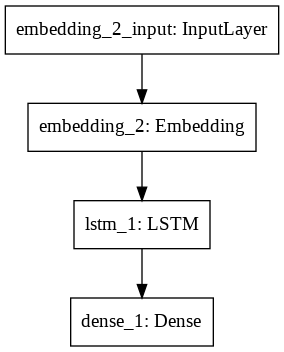

In [19]:
#build the model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                batch_input_shape=[batch_size, None]),
      tf.keras.layers.LSTM(rnn_units,
                           return_sequences=True,
                           stateful=True,
                           recurrent_initializer='glorot_uniform'),
      tf.keras.layers.Dense(vocab_size)
  ])
  return model

model = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

tf.keras.utils.plot_model(model)


In [21]:
#probability distribution of each character of every step and for every sequence in a batch
for input_example_batch, target_example_batch in data.take(1):
  example_batch_predictions = model(input_example_batch)  # ask our model for a prediction on our first batch of training data (64 entries)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")  # print out the output shape

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [24]:
# we can see that the predicition is an array of 64 arrays, one for each entry in the batch
#the prediction for entry in the batch
print(len(example_batch_predictions))
#print(example_batch_predictions)
#examine one prediction
# lets examine one prediction
pred = example_batch_predictions[4]
print(len(pred))
print(pred)


64
100
tf.Tensor(
[[ 0.00392709  0.00052697  0.00258195 ...  0.00247465 -0.00570327
   0.0029251 ]
 [ 0.00015499  0.00185219  0.00272551 ...  0.00143829 -0.00586237
   0.00535482]
 [-0.00289473  0.00404807  0.00021542 ... -0.0025577  -0.00576406
   0.00470834]
 ...
 [-0.00121755  0.0050822  -0.01053139 ... -0.0020628  -0.00039232
  -0.00081037]
 [-0.00249025  0.00805141 -0.00850234 ... -0.00362631 -0.00285595
  -0.00048756]
 [ 0.00387235  0.0076976  -0.00636552 ...  0.00329043 -0.00304087
   0.00087189]], shape=(100, 65), dtype=float32)


In [26]:
time_pred = pred[0]
print(len(time_pred))
print(time_pred)
# If we want to determine the predicted character we need to sample the output distribution (pick a value based on probabillity)
sampled_indices = tf.random.categorical(pred, num_samples=1)

# now we can reshape that array and convert all the integers to numbers to see the actual characters
sampled_indices = np.reshape(sampled_indices, (1, -1))[0]
predicted_chars = int_to_text(sampled_indices)

predicted_chars  # and this is what the model predicted for training sequence 1

65
tf.Tensor(
[ 0.00392709  0.00052697  0.00258195  0.00141243  0.00245173 -0.0021419
  0.00098137 -0.00308436 -0.00205477  0.00324281  0.00329158 -0.00452687
 -0.00074944 -0.00878992 -0.0093905  -0.00073601 -0.0043852  -0.00677202
  0.00792122 -0.00720755 -0.01796879 -0.00377899 -0.01048177 -0.00923503
  0.00379761 -0.00370199  0.01775039 -0.0022816  -0.01099787  0.00054667
  0.00450589  0.00518196  0.00913441  0.0026355  -0.0066516  -0.008534
  0.00072852  0.00304833  0.0085681   0.00734301  0.00294501  0.00531358
  0.00547654 -0.00376287  0.00088327  0.00537215  0.00134862 -0.0175688
  0.00202401 -0.00010984 -0.00492978 -0.00887404  0.0075854   0.00068932
  0.00157686 -0.00681612 -0.00630644  0.00601421  0.00199446 -0.00303641
 -0.00797948  0.00179095  0.00247465 -0.00570327  0.0029251 ], shape=(65,), dtype=float32)


"n,-G&?ngq$UZDs,J$s:rolx pjUz'$s,fJPb;D,Lq\nNVGNCGLdil-DcRnNYhVwgB$o-P&PWpkURYfnk!OPF.POIzMDvN?o'FpVlp"

Creating the Loss function

In [27]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


In [28]:
#compile the model
model.compile(optimizer='adam',loss=loss)


In [30]:
#creating a checkpoints to allow us to continue to train the model based on last progress
checkpoint_dir = './training_checkpoints'
#name the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only=True
)



In [ ]:
#fit the model
history = model.fit(data, epochs=20, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 1323s 8s/step - loss: 2.0400
Epoch 2/20
172/172 [==============================] - 1271s 7s/step - loss: 1.7096
Epoch 3/20
172/172 [==============================] - 1398s 8s/step - loss: 1.5417
Epoch 4/20
172/172 [==============================] - 1318s 8s/step - loss: 1.4447
Epoch 5/20
121/172 [====================>.........] - ETA: 6:05 - loss: 1.3829

In [ ]:
#reloading a model based on epoch 1
'''
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, batch_size=1)
'''


In [ ]:
#after the model has finished training, save the checkpoint
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))


In [ ]:
#reloading at any checkpoint for testing, for examplem at epoch 15
checkpoint_num = 15
model.load_weights(tf.train.load_checkpoint('./training_checkpoints/ckpt_' + str(checkpoint_num)))
model.build(tf.TenorShape([1, None]))


In [ ]:
#a function to generate text, write a poem
def poem_writer(model, start_string):
  num_generate = 1200
  #convert string to numbers
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []
  temperature = 1

  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    #remove the batch dimension
    predictions = tf.squeeze(predictions, 0)
    #using categorical distribution to predict the character the model returns
    predictions = predictions /1
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    input_eval = tf.expand_dim([predicted_id], 0)

    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated)) 


In [ ]:
#test it out
inp = input('Begin your poem: ')
print(generate_text(model, inp))
